### Import all necessary Python libraries

In [ ]:
# imports 
import numpy as np
import scipy.cluster.hierarchy as hac
import random
import matplotlib.cm as cm

from sklearn import metrics
from sklearn import manifold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import Birch

from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot as plt
from scipy import stats
from time import time


### Load Dataset and drop colums that will not be used as features during clustering and drop rows which contains null values

In [21]:
# Loading the dataset and random sub-sampling

n = 542153 #number of records in file
s = 20000 #desired sample size
skip = sorted(random.sample(range(1,n), n-s))

dataset_path  = '../Dataset/training_dataset.csv'
df = read_csv(dataset_path, skiprows=skip)
print "Before dropping rows with null values, shape: ", df.values.shape
df = df.dropna(axis=0, how='any')
print "After dropping rows with null values, shape: ", df.values.shape

df.drop('SHIP_ID', axis=1, inplace=True)
df.drop('SHIPTYPE', axis=1, inplace=True)
df.drop('ARRIVAL_PORT_CALC', axis=1, inplace=True)
df.drop('ARRIVAL_CALC', axis=1, inplace=True)
df.drop('REPORTED_DRAUGHT', axis=1, inplace=True)
df.drop('DEPARTURE_PORT_NAME', axis=1, inplace=True)
df.drop('TIMESTAMP', axis=1, inplace=True)

print df.columns
scaled_features = StandardScaler().fit_transform(df.values)
print "Scaled Features Shape: ", scaled_features.shape

Before dropping rows with null values, shape:  (20000, 12)
After dropping rows with null values, shape:  (11175, 12)
Index([u'SPEED', u'LON', u'LAT', u'COURSE', u'HEADING'], dtype='object')
Scaled Features Shape:  (11175, 5)


### Method for Visualizing Clusters

In [22]:
# Visualize the clustering
def plot_clustering(X_red, X, labels, ax2, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    for i in range(X_red.shape[0]):
        ax2.text(X_red[i, 0], X_red[i, 1], '.',
                 color=plt.cm.spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 12})

    ax2.set_xticks([])
    ax2.set_yticks([])
    if title is not None:
        ax2.set_title(title, size=17)
    ax2.axis('off')
    

### Embedding of the dataset features into 2 dimension and Defining Cluster Counts 

In [23]:
# Initialize Common Stuff
# 2D embedding of the dataset
print("Computing embedding")
scaled_features_red = manifold.SpectralEmbedding(n_components=2).fit_transform(scaled_features)
print("Embedding is Done.")
cluster_size_list = (5, 15, 25)

Computing embedding
Embedding is Done.


## Agglomerative Clustering Implementation

ward : 5.97s
silhouette average:  0.456479659256  cluster count:  5
ward : 5.72s
silhouette average:  -0.0280655865468  cluster count:  15
ward : 6.54s
silhouette average:  -0.0175184366484  cluster count:  25
average : 5.67s
silhouette average:  -0.377613477392  cluster count:  5
average : 5.57s
silhouette average:  -0.335541992231  cluster count:  15
average : 5.89s
silhouette average:  0.0562478680486  cluster count:  25
complete : 6.01s
silhouette average:  -0.183493172598  cluster count:  5
complete : 5.97s
silhouette average:  -0.136612180778  cluster count:  15
complete : 7.02s
silhouette average:  -0.167667664111  cluster count:  25


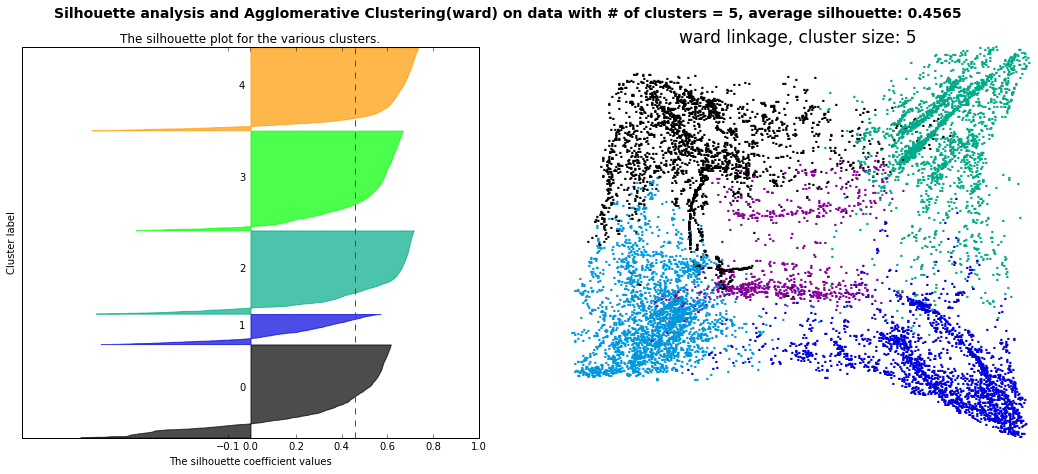

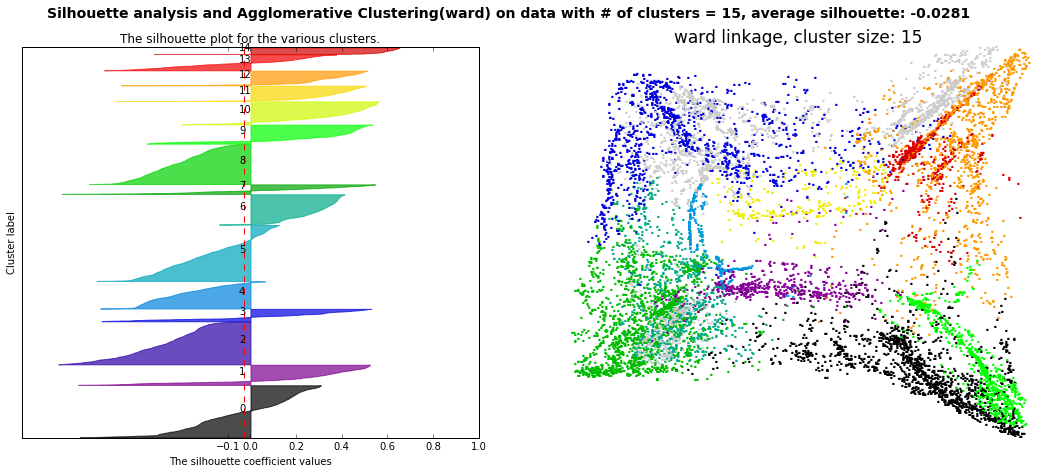

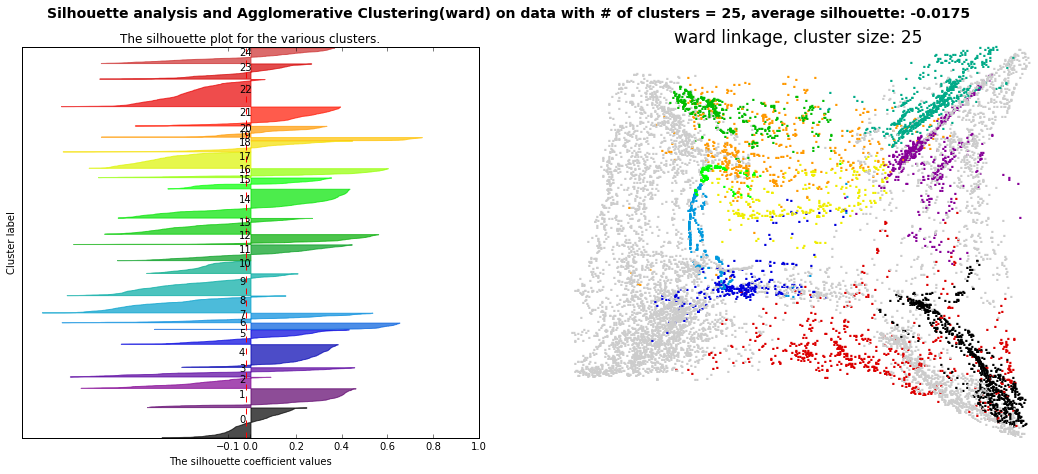

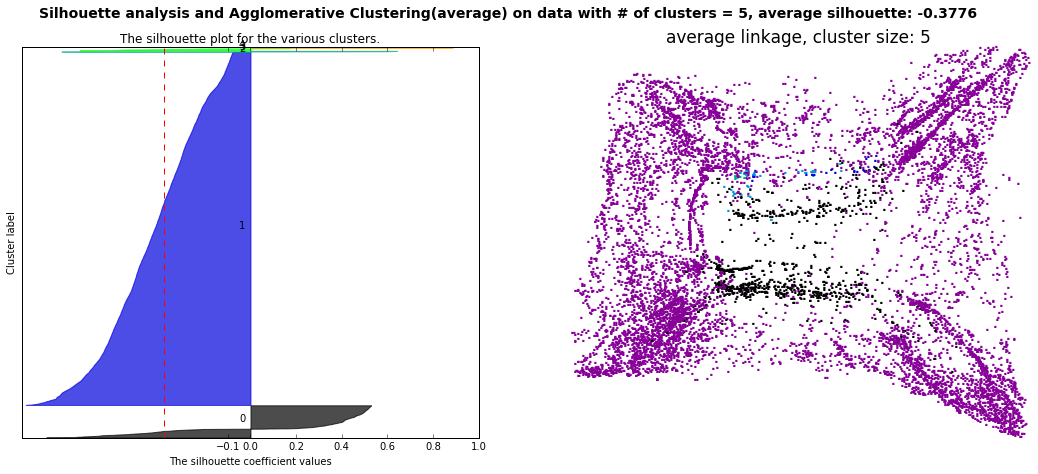

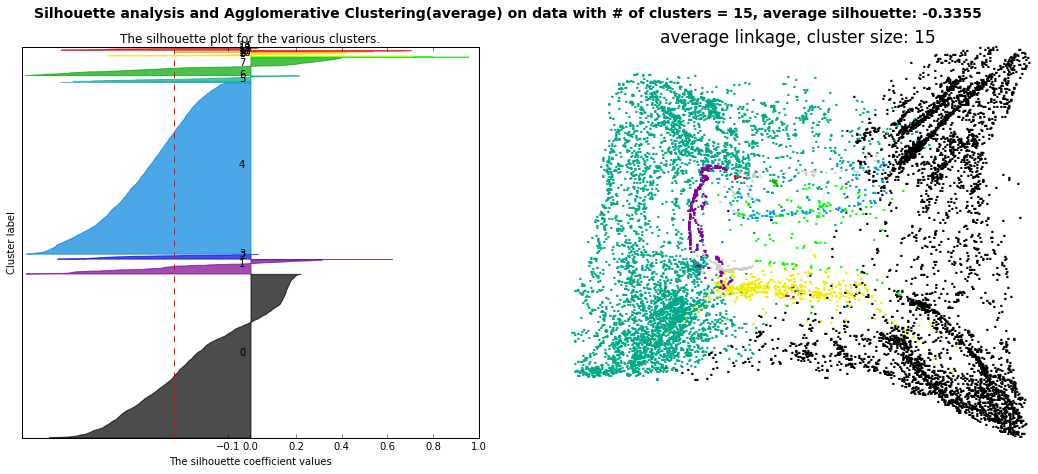

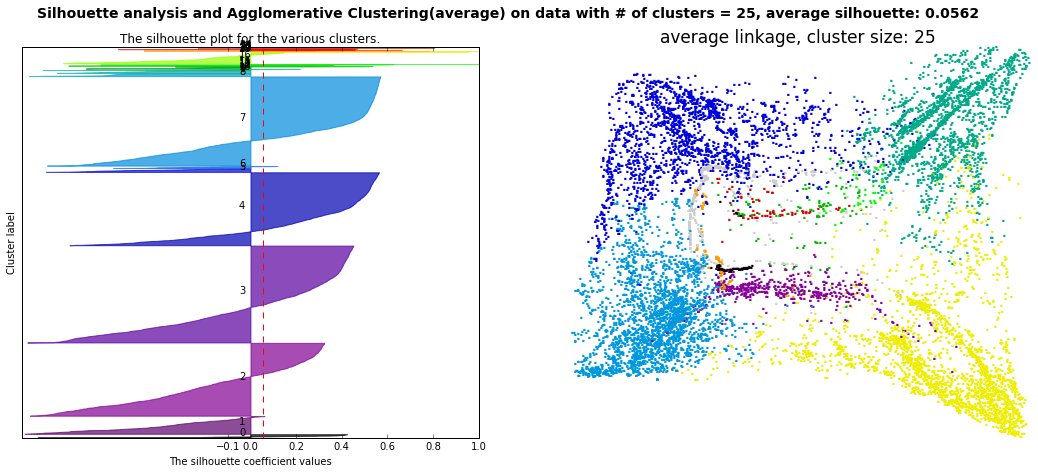

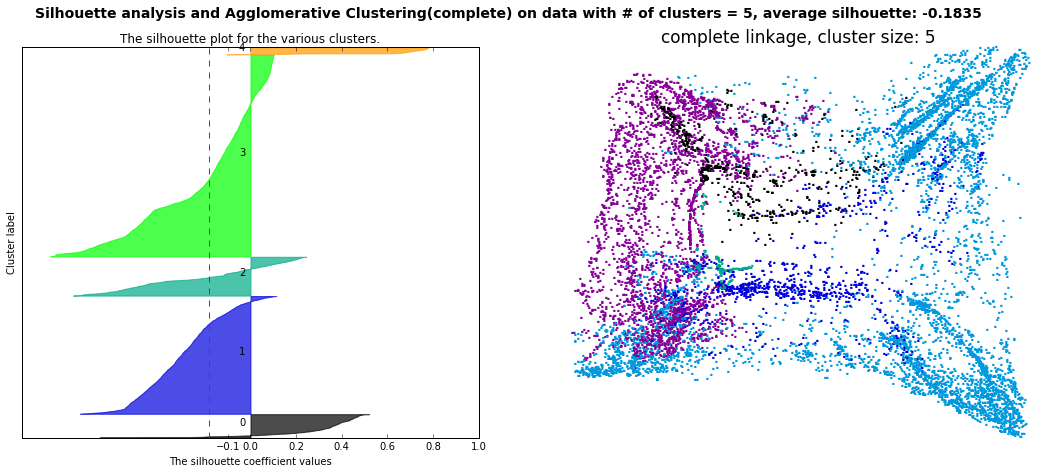

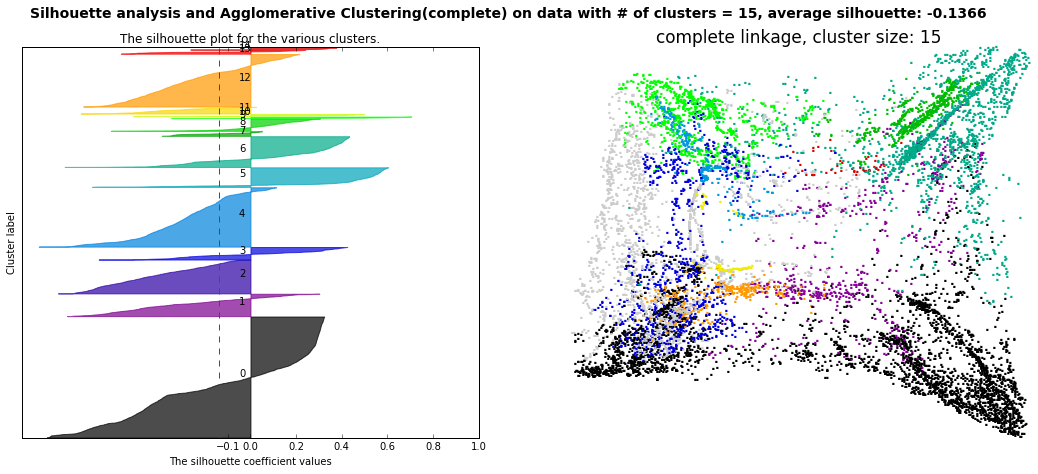

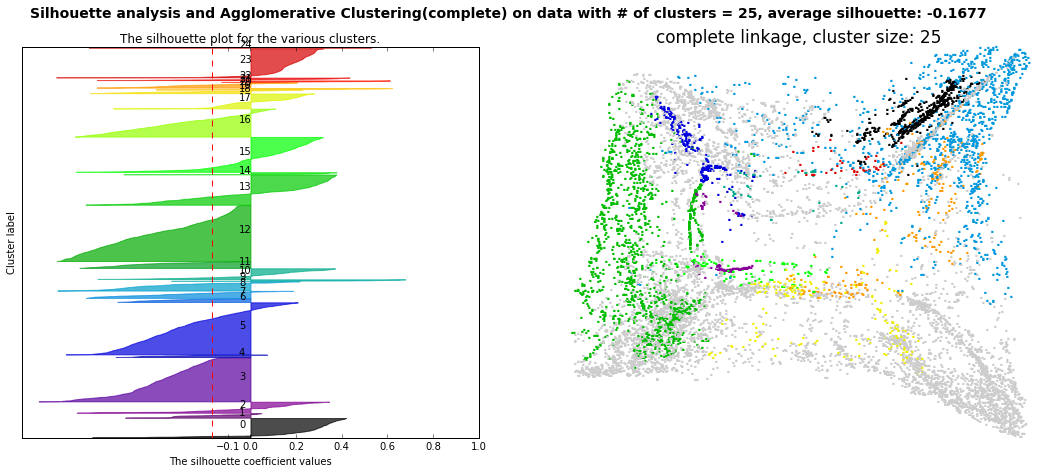

In [24]:
# Agglomerative Clustering
for linkage in ('ward', 'average', 'complete'):
    for cluster_size in cluster_size_list:
        clustering = AgglomerativeClustering(linkage=linkage, n_clusters=cluster_size)
        t0 = time()
        clustering.fit(scaled_features)
        print("%s : %.2fs" % (linkage, time() - t0))

        # Print silhouette score
        silhouette_avg = silhouette_score(scaled_features_red, clustering.labels_)
        print "silhouette average: ", silhouette_avg, " cluster count: ", cluster_size

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(scaled_features_red, clustering.labels_)
        
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        ax1.set_xlim([-1, 1])
        ax1.set_ylim([0, len(scaled_features_red) + (cluster_size + 1) * 10])

        
        y_lower = 10
        for i in range(cluster_size):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[clustering.labels_ == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / cluster_size)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


        plt.suptitle(("Silhouette analysis and Agglomerative Clustering(%s) on data "
                      "with # of clusters = %d, average silhouette: %.4f" % (linkage, cluster_size, silhouette_avg)),
                     fontsize=14, fontweight='bold')

        plot_clustering(scaled_features_red, scaled_features, clustering.labels_, ax2, "%s linkage, cluster size: %d" % (linkage, cluster_size))        
    
plt.show()

## KMeans Clustering

silhouette average:  0.4846448236  cluster count:  5
silhouette average:  0.0162849773239  cluster count:  15
silhouette average:  0.00023335085096  cluster count:  25


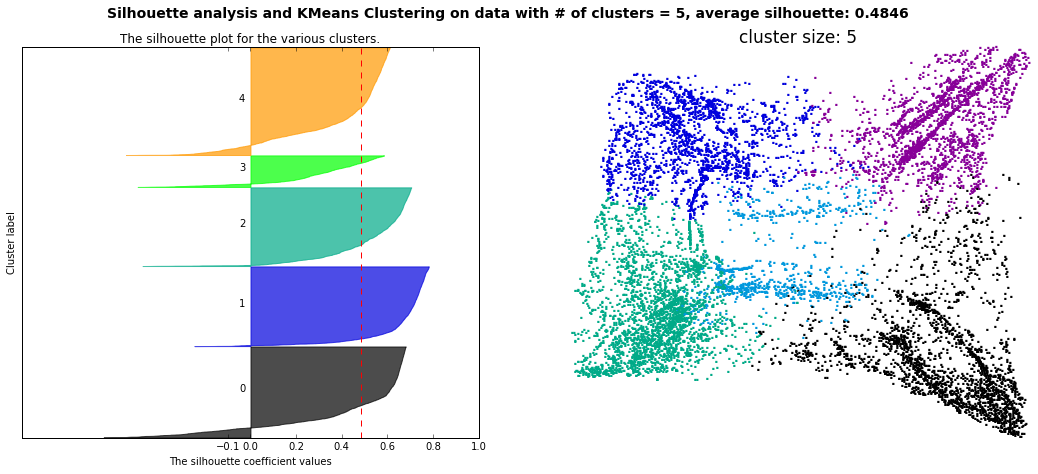

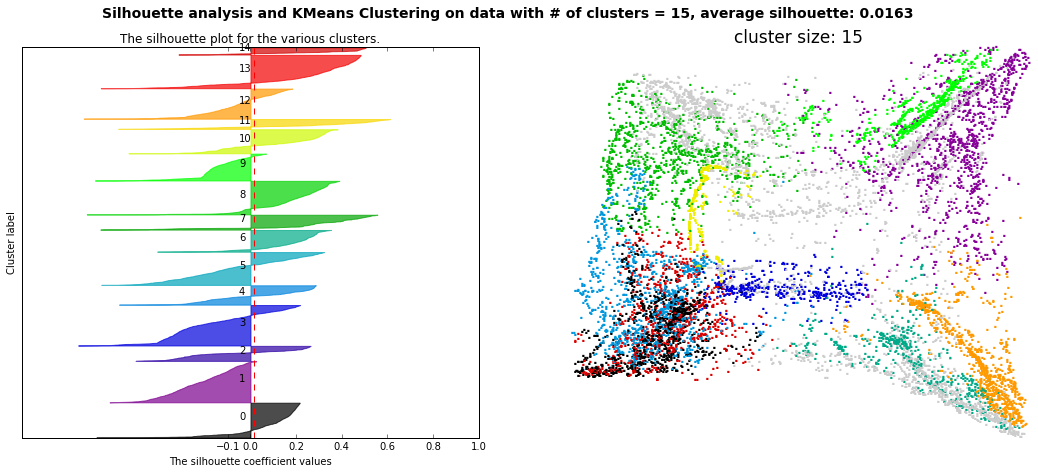

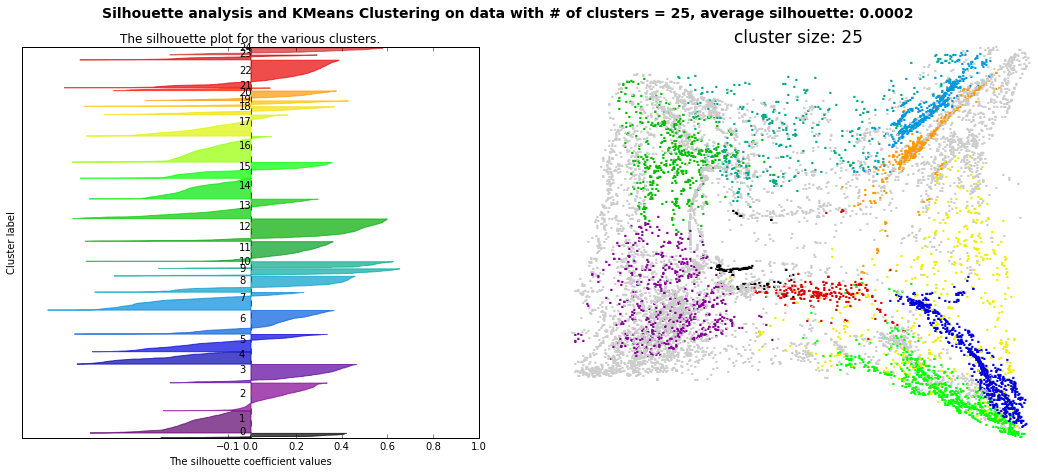

In [25]:
# KMeans Clustering
for cluster_size in cluster_size_list:
    clustering = KMeans(n_clusters=cluster_size, random_state=0)
    clustering.fit(scaled_features)

    # Print silhouette score
    silhouette_avg = silhouette_score(scaled_features_red, clustering.labels_)
    print "silhouette average: ", silhouette_avg, " cluster count: ", cluster_size

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(scaled_features_red, clustering.labels_)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(scaled_features_red) + (cluster_size + 1) * 10])


    y_lower = 10
    for i in range(cluster_size):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[clustering.labels_ == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / cluster_size)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhouette analysis and KMeans Clustering on data "
                  "with # of clusters = %d, average silhouette: %.4f" % (cluster_size, silhouette_avg)),
                 fontsize=14, fontweight='bold')

    plot_clustering(scaled_features_red, scaled_features, clustering.labels_, ax2, "cluster size: %d" % cluster_size)

plt.show()


## Birch Implementation

silhouette average:  0.0727582194333  cluster count:  5
silhouette average:  -0.0719121656918  cluster count:  15
silhouette average:  -0.0436675848317  cluster count:  25


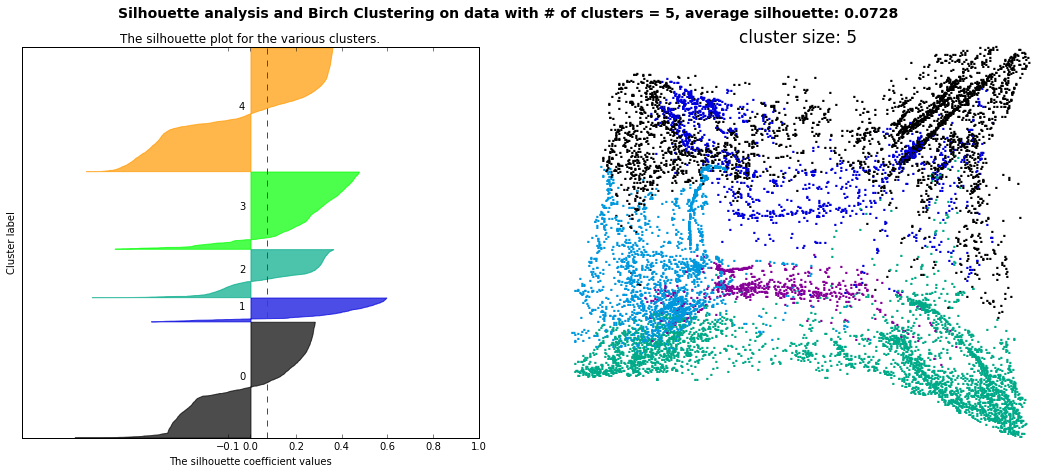

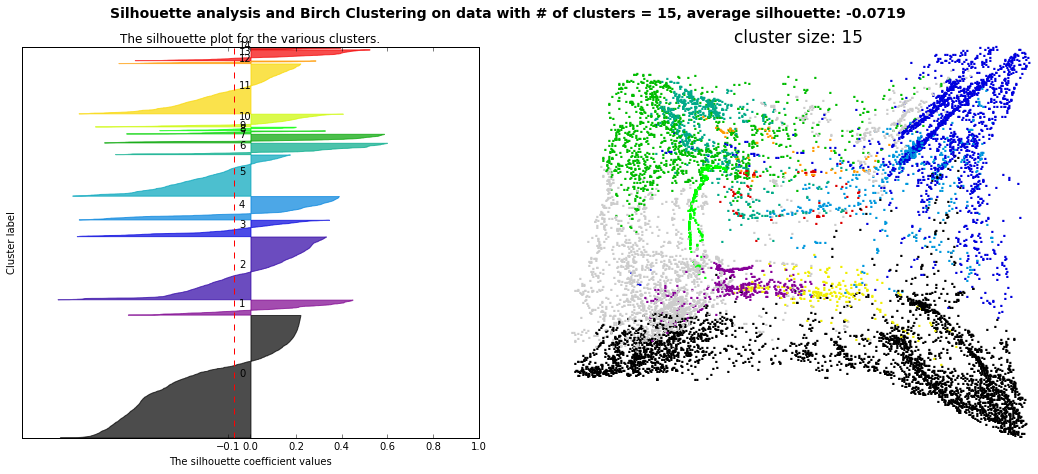

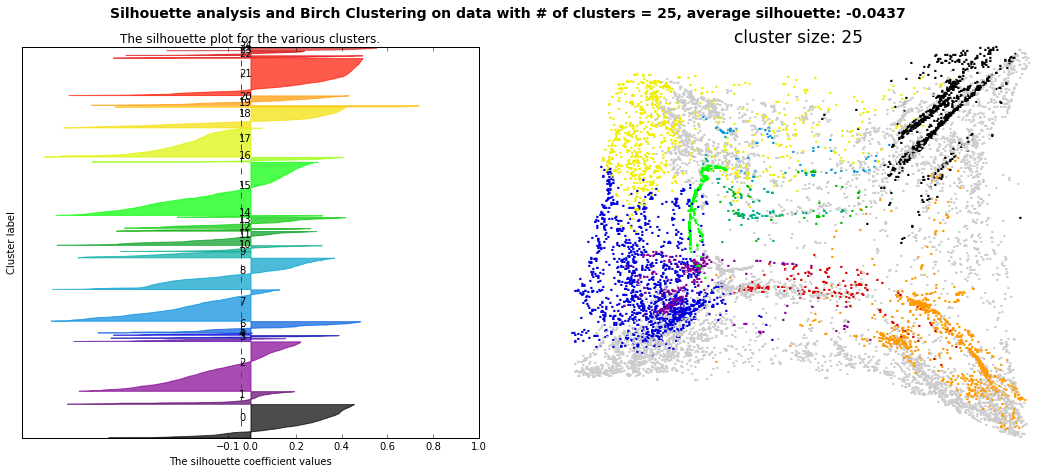

In [26]:
# Birch
for cluster_size in cluster_size_list:
    clustering = Birch(branching_factor=50, n_clusters=cluster_size, threshold=0.5)
    clustering.fit(scaled_features)

    # Print silhouette score
    silhouette_avg = silhouette_score(scaled_features_red, clustering.labels_)
    print "silhouette average: ", silhouette_avg, " cluster count: ", cluster_size

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(scaled_features_red, clustering.labels_)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(scaled_features_red) + (cluster_size + 1) * 10])


    y_lower = 10
    for i in range(cluster_size):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[clustering.labels_ == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / cluster_size)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhouette analysis and Birch Clustering on data "
                  "with # of clusters = %d, average silhouette: %.4f" % (cluster_size, silhouette_avg)),
                 fontsize=14, fontweight='bold')

    plot_clustering(scaled_features_red, scaled_features, clustering.labels_, ax2, "cluster size: %d" % cluster_size)

plt.show()
